# 목차

* 평가기준
* WEAT 구현하기
* 사전학습된 Word Embedding에 WEAT 적용 (1)
* 사전학습된 Word Embedding에 WEAT 적용 (2)
* 사전학습된 Word Embedding에 WEAT 적용 (3)
* 프로젝트 : 모든 장르 간 편향성 측정해 보기
* 회고
* Reference

# 평가기준

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

---

평가문항	상세기준

1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.

> 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.

2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.

> 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.

3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.

> 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

# WEAT 구현하기

WEAT score를 코드로 구현해 봅시다.

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [ ]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

각 단어들이 얼마나 연관이 있는지는 코사인 유사도를 통해 구할 수 있다. 이는 어떤 벡터 공간 내에 단어들을 임베딩한 후 그 벡터를 내적하고 정규화한 값이다.

WEAT 점수는 이 코사인 유사도의 차이를 표준편차로 나눈 값이다. 이 때 중요한 것은 여기서 하나의 단어가 아니라 단어 집합을 사용해 평균을 구한다는 점이다. 즉 2개의 단어쌍이 주어지면 그 단어들을 대표할 수 있는 2개의 단어집합쌍으로 WEAT 점수를 계산한다.

# 사전학습된 Word Embedding에 WEAT 적용 (1)

지금까지 WEAT가 어떻게 계산되는지 확인해보았다. 이제 실제 pretrain된 임베딩 모델을 이용하여 계산하자.

구글에서 학습한 모델을 사용한다.

우선 ~/aiffel/weat 폴더를 만들어 링크를 걸고, 압축을 풀면 대략 3G 정도 된다. (아래 링크에서 다운받아 로컬에서도 확인해볼 수 있다.)

GoogleNews-vectors-negative300.bin.gz

다음 코드에서 data_dir 변수에 본인의 경로를 잘 설정해서 모델을 불러온다.

> 💡 참고  
w2v를 사용하다가 메모리 부족이 발생할 수 있습니다. 이때는 워드 임베딩 내 300만 개의 단어 중 자주 쓰는 단어 50만 개만 꺼내어 사용하도록 아래와 같이 limit 파라미터값을 주면 메모리 사용량을 크게 줄일 수 있습니다.

w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [ ]:
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [ ]:
w2v

w2v에 있는 단어 개수와 벡터 크기를 살펴보자.

> 💡 참고  
2021년 3월, Gensim이 4.0 으로 버전업되면서 KeyedVectors에 vocab dict가 제거되었습니다. 상세한 내용은 아래 링크를 참고해 주세요.

* [Migrating from Gensim 3.x to 4](https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4)

In [ ]:
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

# 코랩은 이전 버전이라서 index_to_key 대신 바로 w2v.vocab을 써야한다.

500000
300
(500000, 300)


w2v에는 limit으로 지정한 갯수(디폴트는 3,000,000개)의 단어가 있고, 각 단어는 300차원을 갖는다는 것을 알 수 있다.

'happy'라는 단어의 벡터를 살펴보자.



In [ ]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

'happy'와 가장 유사한 단어들을 확인한다.

In [ ]:
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

다른 단어들도 살펴보자.

In [ ]:
w2v.most_similar(positive=['family'])

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

오타로 추정되는 몇몇 단어도 보인다. 이 단어들도 데이터 자체에 자주 나왔기 때문에 단어 셋에 포함된 것으로 보인다.

In [ ]:
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529811024665833),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301522850990295),
 ('classroom', 0.6281620264053345),
 ('Schools', 0.6172096133232117)]

위 과정에서 충분히 비슷한 단어들을 잘 나타내는 것을 확인할 수 있었다.

이제 WEAT를 통해 이 모델의 편향성을 확인해보도록 하자. [논문](https://arxiv.org/pdf/1608.07187.pdf)에 있던 단어 셋으로 구성한다.

In [ ]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

과학과 관련된 단어가 남성과 관련된 단어와 가깝고, 예술과 관련된 단어가 여성과 관련된 단어와 가깝게 나타난다. 사람의 편향성을 실험하는 IAT에서도 이와 같게 나타났었다. 많은 사람이 가진 편향이 임베딩 모델에 반영되었다고 볼 수 있다.

이제 다른 셋을 구성해보자. target_X는 인스턴트 식품들로 단어를 구성하였고 target_Y는 그 반대로 구성했다. attribute_A는 인스턴트를 의미하는 단어들로, attributes_B는 그 반대로 구성한다.

이 단어 셋들을 보면 보통 target_X와 attribute_A가 가깝고, traget_Y는 attribute_B와 가깝다고 여길 것이다.

임베딩 모델도 그렇게 생각하는지 확인해보자.

In [ ]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

모델도 우리의 예상과 맞는 방향으로 상당히 높은 수치를 보이는 것을 확인했다. 인스턴트 식품의 예시와 인스턴트를 의미하는 단어가 가까운 것은 당연하다. 이 경우 모델이 편향되어있다기보다 단어의 의미를 잘 파악했다고 볼 수 있다.

동일한 target 셋에 다른 attribute 셋을 만들면 어떻게 될까? attribute_A에는 책과 관련된 단어로 구성하고, attribute_B는 뉴스와 관련된 단어로 구성했다. 이번에는 어떤 결과가 나올지 확인해보자.

In [ ]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

0에 굉장히 가까운 결과를 보인다. 즉, 임베딩 모델이 판단하기에 어느 것끼리 가깝다고 말할 수 없는 것이다.

In [ ]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


# 직접 만드는 Word Embedding에 WEAT 적용 (2)

지금까지는 제시된 모델과 단어들로 WEAT score를 구해보았다. 이제 주어진 데이터로 다음과 같은 과정을 수행해보도록 하자.

1. 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
4. embedding model과 단어 셋으로 WEAT score 구해보기

## 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

synopsis.txt(대략 17MB)에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보가 있다. (개봉된 영화 중 일부만 포함되어있다. 더 많은 영화 정보를 사용하려면 KOBIS에서 확인해보자.) synopsis.txt의 일부를 읽어보자.

synopsis.zip

\$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/synopsis.zip  

\$ mv synopsis.zip ~/aiffel/weat  

\$ cd ~/aiffel/weat && unzip synopsis.zip  

In [ ]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

이제 synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장해보자. konlpy 패키지를 이용한다.

konlpy 패키지가 설치되지 않았다면 아래의 명령어로 설치한다.

$ pip install konlpy

In [ ]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [ ]:
print(len(tokenized))

71156


##2. 추출된 결과로 embedding model 만들기


In [ ]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  # 코랩에서는 vector_size 대신 size 씀
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.9059082269668579),
 ('다큐멘터리', 0.8569833636283875),
 ('드라마', 0.8312686681747437),
 ('영화로', 0.8274846076965332),
 ('형식', 0.7967184782028198),
 ('코미디', 0.7925813794136047),
 ('소재', 0.7855272889137268),
 ('소설', 0.7838225364685059),
 ('주제', 0.7743960618972778),
 ('감동', 0.7665520310401917)]

나만의 Word2Vec이 훈련되었다. 아래와 같이 좀더 확인하자.

In [ ]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7141593098640442),
 ('만남', 0.707089364528656),
 ('진심', 0.7040356397628784),
 ('애정', 0.7009574174880981),
 ('첫사랑', 0.7004190683364868),
 ('가슴', 0.6957396864891052),
 ('이별', 0.6863283514976501),
 ('감정', 0.6863266825675964),
 ('우정', 0.6816571354866028),
 ('열정', 0.6801400184631348)]

In [ ]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.9031574130058289),
 ('배우', 0.8766947984695435),
 ('영감', 0.8717746734619141),
 ('영화감독', 0.8643427491188049),
 ('데뷔', 0.8559778928756714),
 ('공연', 0.8477668762207031),
 ('캐스팅', 0.8458325266838074),
 ('오페라', 0.8453139662742615),
 ('연기', 0.8445311188697815),
 ('출연', 0.8429211974143982)]

유사한 단어들이 잘 나온 것을 보아 훈련이 성공적이라고 할 수 있겠다.

# 사전학습된 Word Embedding에 WEAT 적용 (3)

## 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

WEAT score를 구할 때 단어 셋을 만들어주어야 한다. targets_X, targets_Y, attribute_A, attribute_B를 만들고 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야 한다.

여기서는 두 축을 영화 장르, 영화 구분 정보를 이용한다. (영화 구분 정보란 일반영화, 예술영화, 독립영화로 구분된 정보이다. KOBIS에서 제공한 정보를 기준으로 분류하였다.)

영화 구분

* synopsis_art.txt : 예술영화
* synopsis_gen.txt : 일반영화(상업영화)

그 외는 독립영화 등으로 분류된다.

장르 구분

synopsis_SF.txt: SF

synopsis_가족.txt: 가족

synopsis_공연.txt: 공연

synopsis_공포(호러).txt: 공포(호러)

synopsis_기타.txt: 기타

synopsis_다큐멘터리.txt: 다큐멘터리

synopsis_드라마.txt: 드라마

synopsis_멜로로맨스.txt: 멜로로맨스

synopsis_뮤지컬.txt: 뮤지컬

synopsis_미스터리.txt: 미스터리

synopsis_범죄.txt: 범죄

synopsis_사극.txt: 사극

synopsis_서부극(웨스턴).txt: 서부극(웨스턴)

synopsis_성인물(에로).txt: 성인물(에로)

synopsis_스릴러.txt: 스릴러

synopsis_애니메이션.txt: 애니메이션

synopsis_액션.txt: 액션

synopsis_어드벤처.txt: 어드벤처

synopsis_전쟁.txt: 전쟁

synopsis_코미디.txt: 코미디

synopsis_판타지.txt: 판타지

이번에는 예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고, 드라마 장르와 액션 장르라는 장르구분을 attribute로 삼아 WEAT score를 계산한다. 즉 드라마 장르에는 예술영화적 성격이 강하고, 액션 장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 보겠다는 것이다.

'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고, 위에서 했던 것과 마찬가지로 명사에 대해서만 추출하여 art, gen 변수에 할당한다.

In [ ]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


In [ ]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요하다. 예를 들어 예술영화라는 개념을 가장 잘 대표하는 단어들을 art_txt를 처리해서 만든 art라는 단어 리스트에서부터 골라내야 한다. 이를 위해서 상식을 동원해서 적절한 단어를 골라낼 수도 있지만 보다 납득할 수 있는 보편적인 방법을 사용하는 것이 좋다.

어떤 개념을 나타내는 단어를 선정하는 방법으로 어떤 것이 적당할까? 꼭 정해진 방법이 있는 것은 아니지만 이번 경우에는 예술영화, 일반영화라는 영화 구분별로 시놉시스를 모아 데이터를 구성했다. 그렇다면 예술영화를 잘 대표하는 단어란 예술영화 시놉시스에는 자주 나타나지만 그 외 다른 구분의 영화(예를 들어 일반영화) 시놉시스에는 자주 나타나지 않는 것을 고르는 것이 적당할 것이다.

이런 것과 비슷한 개념의 단어 분석 방식 중, TF-IDF라는 것이 있다.  코퍼스에서 자주 나타나는(TF가 높은) 단어이지만, 다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정하는 방식이다. 이번에는 단어 셋 구성을 위해 TF-IDF방식을 사용한다.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [ ]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출하려 했는데 양쪽에 중복된 단어가 너무 많다. 두 개념축이 대조되도록 대표하는 단어 셋을 만들고 싶기 때문에 단어가 서로 중복되지 않게 단어셋을 추출해야 한다. 우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출한다.

In [ ]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

추출된 단어들을 보자.

In [ ]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [ ]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


이번에는 장르별 대표 단어를 추출한다. 이번에는 드라마 장르와 액션 장르를 다루어 보자. 그러나 드라마와 액션 단 2개의 장르만 고려하기보다는 여러 장르의 코퍼스를 두루 고려하는 것이 특정 장르를 대표하는 단어를 선택하는 데 더 유리할 것이다. 이번에는 주요 장르 5개만 고려했다.

In [ ]:
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

print("슝~")

슝~


In [ ]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 33151)


In [ ]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

드라마: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 


각 장르를 대표하는 단어들을 추출해보았다. 우리가 생각했던 직관과 데이터에 있는 단어들이 어느 정도 맞는 것으로 보인다. 중복된 것이 종종 있지만 art, gen 두 개의 단어 셋을 추출했을 때에 비해 적다. 그러므로 일단 중복을 체크해서 삭제하기보다 그대로 사용한다.

## 4. embedding model과 단어 셋으로 WEAT score 구해보기

이제 WEAT_score를 구한다.

traget_X는 art, target_Y는 gen, attribute_A는 '드라마', attribute_B는 '액션' 과 같이 정해줄 수 있다.

target_X 는 art, target_Y 는 gen으로 고정하고 attribute_A, attribute_B를 바꿔가면서 구해보자. 구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담는다.

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

슝~


In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


matrix가 채워졌다. WEAT score 값을 보고, 과연 우리의 직관과 비슷한지 살펴보자?

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

드라마 멜로로맨스 -0.845735
드라마 액션 -0.038628753
드라마 코미디 -0.06469906
드라마 전쟁 0.37066457
드라마 공포(호러) -0.20732243
멜로로맨스 액션 0.7524959
멜로로맨스 코미디 0.9031239
멜로로맨스 전쟁 0.76612204
멜로로맨스 공포(호러) 0.7478848
액션 코미디 0.023618076
액션 전쟁 0.5183955
액션 공포(호러) -0.21370365
코미디 전쟁 0.43420947
코미디 공포(호러) -0.29048675
전쟁 공포(호러) -0.49928984


WEAT score가 0.8 이상, -0.8 이하의 경우만 해석해 보면 아래와 같다.

* 예술영화와 일반영화, 그리고 드라마와 멜로로맨스의 WEAT score의 의미를 해석해보면 예술영화는 멜로로맨스, 일반영화는 드라마와 가깝다고 볼 수 있다. 
* 예술영화와 일반영화, 그리고 멜로로맨스와 코미디의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 코디미는 일반 영화와 가깝다고 볼 수 있다.
* 예술영화와 일반영화, 그리고 멜로로맨스와 전쟁의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 전쟁은 일반 영화와 가깝다고 볼 수 있다.

<AxesSubplot:>

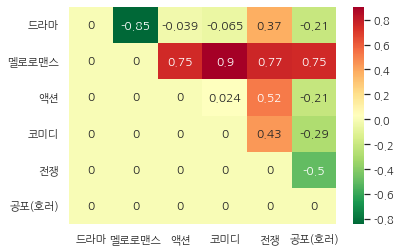

In [ ]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

지금까지 word embedding model에 있는 편향성을 확인해보기 위해 WEAT score를 시도해보았다. 이 학습을 통해 우리가 가진 데이터로 word embedding model을 만들 수 있고, 이 모델이 특정 분야에 대해 편향이 되어있는지 확인해볼 수 있게 되었다.

In [ ]:
# 메모리를 다시 비워줍시다.

del model

# 프로젝트 : 모든 장르 간 편향성 측정해 보기

지금까지 우리는 영화 시놉시스 코퍼스를 가지고 영화 구분과 영화 장르 간에 내재된 편향성을 측정하는 작업을 진행해 보았다. 어느 정도는 우리의 상식과 일치하는 편향성이 측정되었을 것이다.

이번에는 모든 장르에 대해 영화 구분과의 편향성 정도를 측정해 본다. 대부분의 과정은 이전 스텝에서 이미 진행한 내용을 참고해서 동일하게 진행 가능할 것이다.

## 라이브러리 임포팅

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Okt
import os

## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

명사 뿐만이 아닌 형용사나 동사를 뽑아낼 수도 있지만 여기선 명사로 진행한다.

In [ ]:
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:
                res.append(w[0])
        tokenized.append(res)

## STEP 2. 추출된 결과로 embedding model 만들기

In [ ]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

[('작품', 0.8902412056922913),
 ('다큐멘터리', 0.8519894480705261),
 ('드라마', 0.8175089359283447),
 ('영화로', 0.8006657958030701),
 ('코미디', 0.7887648940086365),
 ('주제', 0.7822786569595337),
 ('스토리', 0.7805757522583008),
 ('형식', 0.775380551815033),
 ('인터뷰', 0.772371232509613),
 ('소재', 0.7720241546630859)]

유사한 단어들을 출력해보니 임베딩 모델이 잘 만들어졌음을 확인할 수 있었다.

## STEP 3. target, attribute 단어 셋 만들기

이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있었다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미친다.

TF-IDF는 거의 같은 의미를 가진 여러 단어들을 모두 구분한다는 문제점과 단어를 얻어내는 문서셋의 영향을 크게 받는다는 문제점이 있다. 하나의 의미를 갖는 여러 표현들이 존재한다면 이들의 빈도가 모두 나눠져 들어간다는 것이다. 그래서 이 문제를 해결하기 위해 단어셋은 적당한 크기를 가져야만 한다. 너무 크면 문서와 관련이 적은 단어가 포함될 것이고, 너무 작으면 중요하지만 빈도가 나눠진 단어를 놓치게 되기 때문이다. 그리고 선정된 문서가 우리의 목적에 적합하지 않다면 당연히 좋은 결과를 얻기 힘들 것이다.

나는 이미 사용한 15개의 단어셋 크기가 나쁘지 않아 보였기 때문에 (앞서 일부 사용해본 결과를 보고) 이 크기를 그대로 사용했다. 그리고 TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있다. 따라서 예술영화를 대표하는 단어셋과 일반영화를 대표하는 단어셋에서 중복된 단어들을 모두 제거해보았다.

그 외에 TF-IDF 방법이 단어만 가져오기 때문에 맥락을 포함한 임베딩이 아니라 단어 그 자체를 바로 임베딩하므로 동음이의어 등의 처리에서 불리하다는 문제도 있으나 이번 프로젝트에서는 다행히 이 문제가 발생하지 않았다.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

여기서도 형용사와 동사는 사용하지 않고 명사만을 추출한다.

In [ ]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


임베딩 결과 확인

In [ ]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
m1 = X[0].tocoo()
m2 = X[1].tocoo()

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)
w2.sort(key=lambda x: x[1], reverse=True)

for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')
    

for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [ ]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [ ]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [ ]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [ ]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']

genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [ ]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [ ]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

예술영화, 일반영화를 대표하는 단어 중 중복되는 단어들을 모두 삭제한다.

In [ ]:
w1_, w2_ = [], []
for i in range(len(w1)):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])

for i in range(len(w2)):
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

target_art, target_gen = [], []
for i in range(len(w1)):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

for i in range(len(w2)):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

## STEP 4. WEAT score 계산과 시각화

영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화 해보자. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋다.

In [ ]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T) / (norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return (mean_X - mean_Y) / std_dev

앞에서 이미 살펴본 식이지만 다시 확인해보자.

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

우리에게 필요한 크기 만큼의 0으로 채워진 행렬 준비한다.

In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.5200951
SF 공연 -0.61099505
SF 공포(호러) -0.4418813
SF 기타 -0.6821141
SF 다큐멘터리 -0.59882617
SF 드라마 -0.5956922
SF 멜로로맨스 -0.5870759
SF 뮤지컬 -0.6224975
SF 미스터리 -0.5084538
SF 범죄 -0.54513603
SF 사극 -0.5144201
SF 서부극(웨스턴) -0.40544584
SF 성인물(에로) -0.6275534
SF 스릴러 -0.5256727
SF 애니메이션 -0.63883644
SF 액션 -0.4648965
SF 어드벤처 -0.39277202
SF 전쟁 -0.4345209
SF 코미디 -0.55171233
SF 판타지 -0.5658443
가족 공연 -0.38040826
가족 공포(호러) 0.5228865
가족 기타 -0.62302226
가족 다큐멘터리 0.08239705
가족 드라마 -0.5034646
가족 멜로로맨스 -0.5366519
가족 뮤지컬 -0.5267166
가족 미스터리 0.2665057
가족 범죄 0.2737962
가족 사극 0.4837081
가족 서부극(웨스턴) 0.6336698
가족 성인물(에로) -0.66071796
가족 스릴러 0.14241011
가족 애니메이션 -0.18851757
가족 액션 0.54634774
가족 어드벤처 0.63295645
가족 전쟁 0.42423803
가족 코미디 0.12094457
가족 판타지 0.33124506
공연 공포(호러) 0.621277
공연 기타 -0.5400149
공연 다큐멘터리 0.3582255
공연 드라마 -0.05978426
공연 멜로로맨스 -0.30969736
공연 뮤지컬 -0.367747
공연 미스터리 0.41781136
공연 범죄 0.49485588
공연 사극 0.689294
공연 서부극(웨스턴) 0.70969325
공연 성인물(에로) -0.49046275
공연 스릴러 0.3275149
공연 애니메이션 0.19247359
공연 액션 0.69852155
공연

<AxesSubplot:>

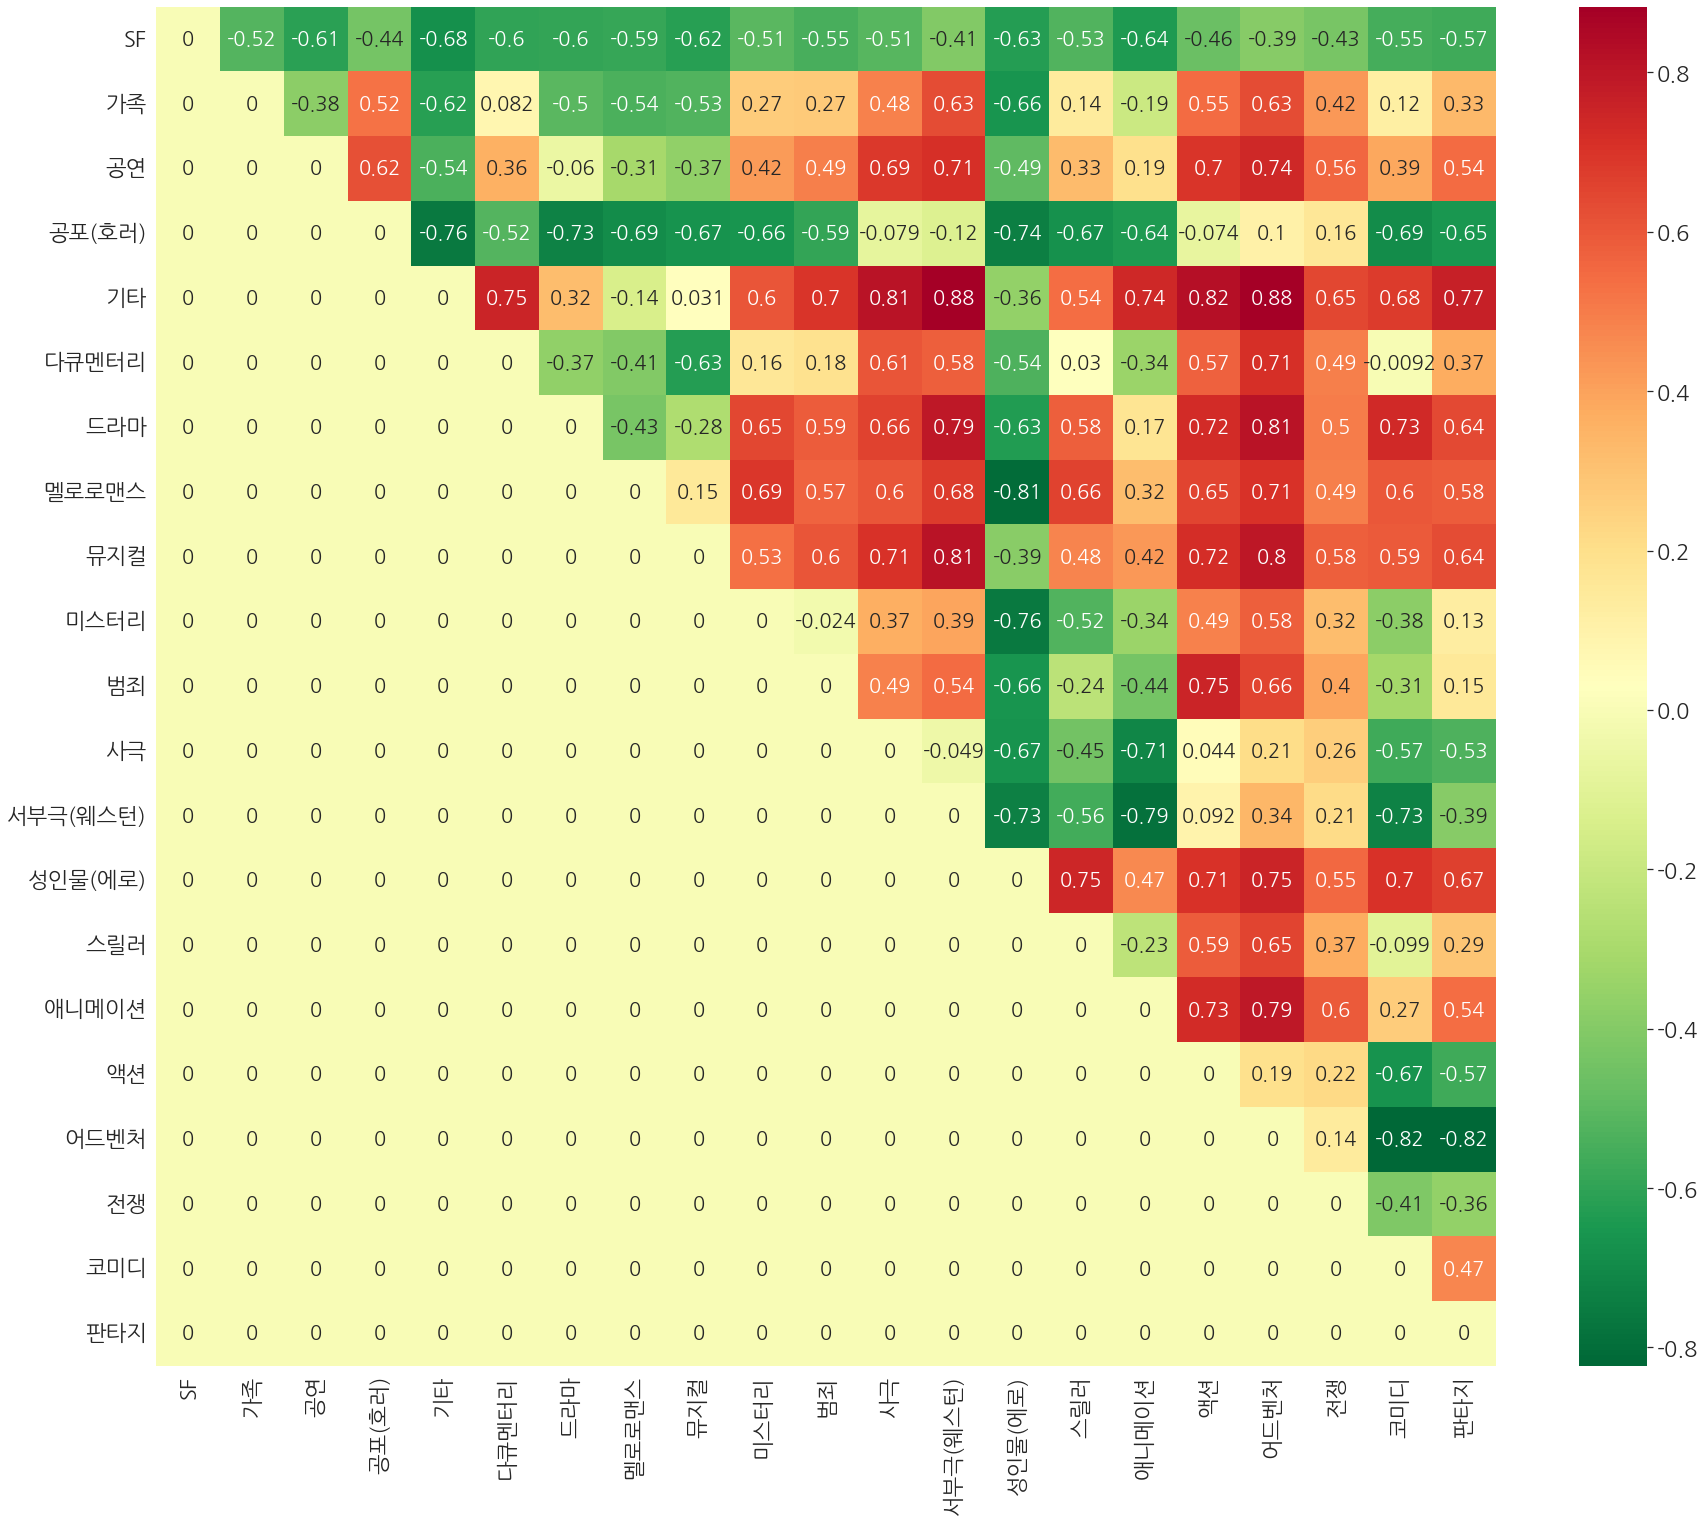

In [ ]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic', font_scale=2)

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(30,25))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, annot_kws={'size':20}, cmap='RdYlGn_r')
ax

결과를 천천히 살펴보니 적어도 나의 직관과 어느 정도 일치하는 결과를 얻을 수 있었다.

# 회고

이번 노드에서 가장 중요한 개념은 WEAT 점수를 계산하는 방법론과 TF-IDF 를 통해 단어셋을 추출하는 것이었다.

WEAT 점수는 단어쌍의 편향성을 보기 위해 편향축을 나타내는 두 단어와 편향성을 알아볼 두 단어를 필요로 한다. 이 때 단어들은 임베딩 되어 벡터 공간 내에 존재하는데 편향축을 담당하는 두 벡터를 잇는 선이 새로운 기저가 되는 것이다. 따라서 우리가 찾고자 하는 두 단어를 잇는 선이 이 새로운 기저에 수직한다면 편향성은 0에 가까워지고 반대로 방향이 일치한다면 편향성은 증가한다. WEAT 점수는 그 식에 의해 절대값의 최대값은 2 이다.

이 때 단어로만 유사도를 측정하지 않고 유사한 의미를 가진 단어 집합을 사용해 평균을 내고 표준편차로 정규화해서 WEAT 점수를 구한다. 그리하여 좀 더 명확하게 편향성을 측정한다.

여기서 사용되는 단어집합은 TF-IDF 방법을 사용해 각각의 문서에서 얻어낸 것들이다. 우선 문서들로부터 형태소 분석기를 통해 명사인 단어들만 추출했다. 형태소 분석기를 사용하면 특정 품사의 단어들만 가져오는 것이 가능하고 형용사나 동사 역시 추출할 수 있다. 이 때 다른 품사가 아닌 명사를 가져온 이유는 일반적으로 중요한 단어는 주어나 목적어로써 명사로 사용되는 경우가 많기 때문이다. 그런데 한국어는 영어 같은 언어와 달리 동사 중심적인데도 불구하고 동사는 사용하지 않았다. 그 이유는 우리가 찾는 단어집합이 영화 장르의 특징을 설명하는 단어들이기 때문이다. 나는 동사들이 문장의 의미에서 중요한 역할을 할 지언정 영화의 특징을 포착하는 데에는 큰 도움이 되지 않을 것이라고 생각했다.

그리고 예술영화와 일반영화를 설명하는 단어집합에서 중복되는 것들을 모두 제거해 구분의 정도를 높였다. 하지만 영화 장르를 설명하는 단어집합은 따로 건들지 않았는데 여기서는 중복인 단어가 쓰이더라도 그것이 해당 장르를 설명하는데 중요한 역할을 할 수 있기 때문이다. 그리고 유사한 장르라면 중복되는 단어가 나오더라도 당연하다고 보았다. 물론 모든 장르에서 똑같이 중복이라면 모델의 성능에 좋지 않은 영향을 미치겠지만 단어집합의 크기가 15 이므로 그런 단어가 존재하더라도 영향이 작을 것이라 보았다.

결과를 보면 대부분은 직관과 일치하게끔 나온 것으로 보인다. SF, 공포 영화는 일관적으로 일반 영화로 편향되었고 멜로로맨스, 뮤지컬 영화는 일관적으로 예술 영화로 편향되었다.

나는 결과를 얻기 전에 일반 영화의 단어집합에서 '애니메이션', '다큐멘터리', '섹스' 등의 단어가 있었으므로 각각 애니메이션, 다큐멘터리, 성인물(에로) 장르는 일반영화로 강하게 편향될 것으로 예상했었다. 하지만 성인물(에로)를 제외한 두 장르는 반반 정도로 그다지 편향되지 않은 모습을 보였다.

이런 결과가 나온 이유는 TF-IDF 방법과도 관련이 있다. 우리가 사용한 문서는 시놉시스였는데 애니메이션의 시놉시스에서 '애니메이션'이라는 단어가 쓰이는 비중이 높을 것으로 보이지는 않는다. 다큐멘터리 장르 역시 마찬가지이다. 따라서 선택된 단어들만을 보아서는 예측과 다른 결과가 나올 가능성이 높았던 것이다.

# Reference

https://blog.marketmuse.com/why-tf-idf-doesnt-solve-your-content-and-seo-problem-but-feels-like-it-does/ TF-IDF 방법의 문제점

https://mirandaherr.tistory.com/21, https://blog.naver.com/jinwan0315/222816224845 히트맵 그리기